# Frame sampling

## Notebook set-up

In [1]:
# Set notebook root to project root
from helper_functions import set_project_root

set_project_root()

# Standard library imports
from pathlib import Path
from random import shuffle

# Third party imports
import h5py
import matplotlib.pyplot as plt
import numpy as np

# Local imports
from ariel_data_preprocessing.utils import load_masked_frames
import configuration as config

# Make sure the figures directory exists
figures_dir = f'{config.FIGURES_DIRECTORY}/signal_extraction'
Path(figures_dir).mkdir(parents=True, exist_ok=True)

Working directory: /mnt/arkk/kaggle/ariel-data-challenge


## 1. Load corrected/extracted data for a sample planet

In [2]:
# Load corrected/extracted data for a sample planet
with h5py.File(f'{config.PROCESSED_DATA_DIRECTORY}/train.h5', 'r') as hdf:
    signal, planet_id = load_masked_frames(hdf, planet='random', return_id=True)

## 2. Sample frames

In [3]:
n_samples = 12

# Generate shuffled indices
indices = list(range(signal.shape[0]))
shuffle(indices)

# Batch the indices into samples groups
sample_indices = np.array_split(indices, n_samples)


# Generate samples
print(f'Generating {len(list(sample_indices))} samples for planet {planet_id}')
samples = [signal[sorted(list(batch)), :] for batch in sample_indices]

Generating 12 samples for planet 3798447886


In [4]:
min_frames = signal.shape[0]

for sample in samples:
    if sample.shape[0] < min_frames:
        min_frames = sample.shape[0]

print(f'Sampling down to {min_frames} frames per sample')

for i, sample in enumerate(samples):
    samples[i] = sample[:min_frames, :]

samples = np.array(samples)
frames_lost = signal.shape[0] - (samples.shape[1] * samples.shape[0])
print(f'Samples shape: {samples.shape}')
print(f'Frames lost: {frames_lost}')

Sampling down to 452 frames per sample
Samples shape: (12, 452, 283)
Frames lost: 2


## 3. Plot samples

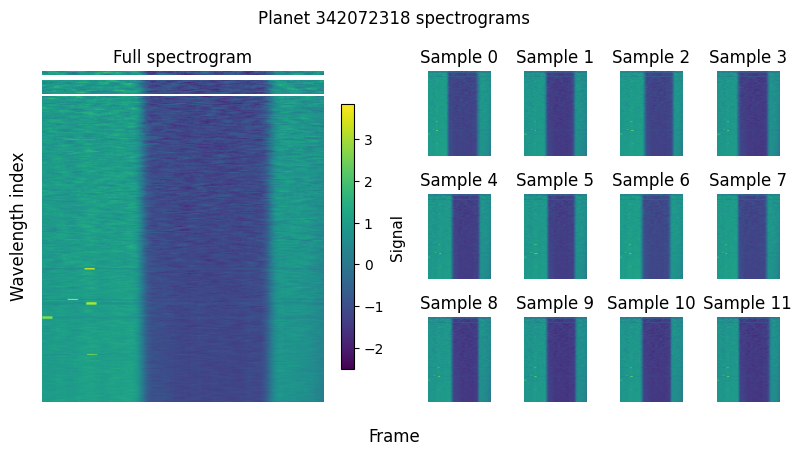

In [6]:
fig = plt.figure(figsize=(1 * 8, 1.5 * 3))

fig.suptitle(f'Planet {config.SAMPLE_PLANET} spectrograms')
fig.supxlabel('Frame')
fig.supylabel('Wavelength index')

gs = fig.add_gridspec(3, 8)
ax1 = fig.add_subplot(gs[0:3, 0:4])

ax1.set_title('Full spectrogram')
im = ax1.imshow(np.transpose(signal), aspect='auto', cmap='viridis')
cbar = plt.colorbar(im, shrink=0.8)
cbar.set_label('Signal', fontsize=11)
ax1.axis('off')

row = 0
col = 4
axs = []

with h5py.File(f'{config.PROCESSED_DATA_DIRECTORY}/train.h5', 'r') as hdf:
    for i, sample in enumerate(samples):

        if col == 8:
            col = 4
            row += 1

        axs.append(fig.add_subplot(gs[row, col]))

        axs[-1].set_title(f'Sample {i}')
        axs[-1].imshow(np.transpose(sample), aspect='auto', cmap='viridis')
        axs[-1].axis('off')

        col += 1

plt.tight_layout()

plt.savefig(
    f'{figures_dir}/02.7.1-samples_spectrograms.jpg',
    dpi=config.STD_FIG_DPI,
    bbox_inches='tight'
)